# Exploration of visualising conflict activity in Ukraine/Russia, using NASAs FIRM datasets.

WIP

To-do:

- implement animated plots
- pgeocode queried location heatmaps
- functionalise formatted heatmap

In [44]:
import geopandas
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import pandas as pd
pd.options.mode.chained_assignment = None
from geodatasets import get_path
import pgeocode as pgc
import plotly.express as px
import nbformat
import contextily as cx
import seaborn as sns
from matplotlib.gridspec import GridSpec
# create subset
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colorbar import ColorbarBase

In [13]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [14]:
path = get_path("naturalearth.land")
world = geopandas.read_file(path)

For recent (past 10 days) data, we can make requests using NASAs API

In [15]:
with open('data/nasa_key.txt', 'r') as file:
    MAP_KEY = file.read().rstrip()

In [16]:
url = "https://firms.modaps.eosdis.nasa.gov/mapserver/mapkey_status/?MAP_KEY=" + MAP_KEY
try:
    df = pd.read_json(url, typ="series")
    display(df)
except:
    # possible error, wrong MAP_KEY value, check for extra quotes, missing letters
    print("There is an issue with the query. \nTry in your browser: %s" % url)

transaction_limit             5000
current_transactions           485
transaction_interval    10 minutes
dtype: object

In [17]:
def get_transaction_count():
    count = 0
    try:
        df = pd.read_json(url, typ="series")
        count = df["current_transactions"]
    except:
        print("Error in our call.")
    return count

We can see available data sources (different satellites/sensors) along with the date ranges available:

In [18]:
da_url = (
    "https://firms.modaps.eosdis.nasa.gov/api/data_availability/csv/" + MAP_KEY + "/all"
)
df = pd.read_csv(da_url)
display(df)

data_id    min_date    max_date
0         MODIS_NRT  2024-06-01  2024-09-25
1          MODIS_SP  2000-11-01  2024-05-31
2  VIIRS_NOAA20_NRT  2019-12-04  2024-09-25
3  VIIRS_NOAA21_NRT  2024-01-17  2024-09-25
4    VIIRS_SNPP_NRT  2024-04-01  2024-09-25
5     VIIRS_SNPP_SP  2012-01-20  2024-03-31
6       LANDSAT_NRT  2022-06-20  2024-09-24
7          GOES_NRT  2022-08-09  2024-09-25
8          BA_MODIS  2000-11-01  2024-04-01

Lets look at the past 10 days of data from Ukraine & Russia, using the MODIS near-real-time dataset

In [19]:
past_n_days = 10

In [20]:
rus_url = f"https://firms.modaps.eosdis.nasa.gov/api/country/csv/{MAP_KEY}/MODIS_NRT/RUS/{past_n_days}"
df_rus = pd.read_csv(rus_url)

In [21]:
ukr_url = f"https://firms.modaps.eosdis.nasa.gov/api/country/csv/{MAP_KEY}/MODIS_NRT/UKR/{past_n_days}"
df_ukr = pd.read_csv(ukr_url)

In [22]:
df_ukr["country"] = "UKR"
df_rus["country"] = "RUS"
df = pd.concat([df_rus, df_ukr])

In [23]:
%matplotlib inline

Alternatively, we can download historic data from NASA directly, & read those dataframes

In [99]:
df_rus = pd.read_csv("data/modis_2023_Russian_Federation.csv")
df_ukr = pd.read_csv("data/modis_2023_Ukraine.csv")
df_ukr["country"] = "UKR"
df_rus["country"] = "RUS"
df = pd.concat([df_rus, df_ukr])

---
We can create a geopandas geodataframe from this data

In [24]:
df["area"] = df["scan"] * df["track"]
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)

Plotting all activity from this dataset as a color-coded heatmap, with different palettes for signals from either country

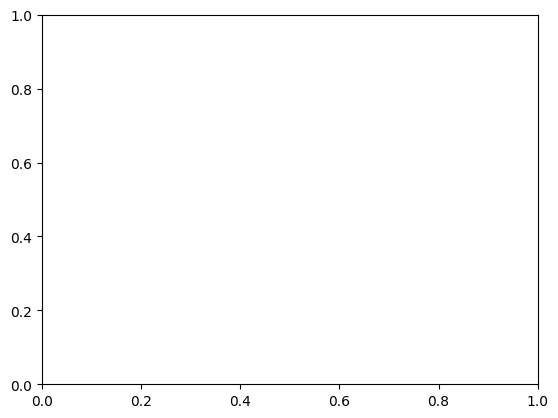

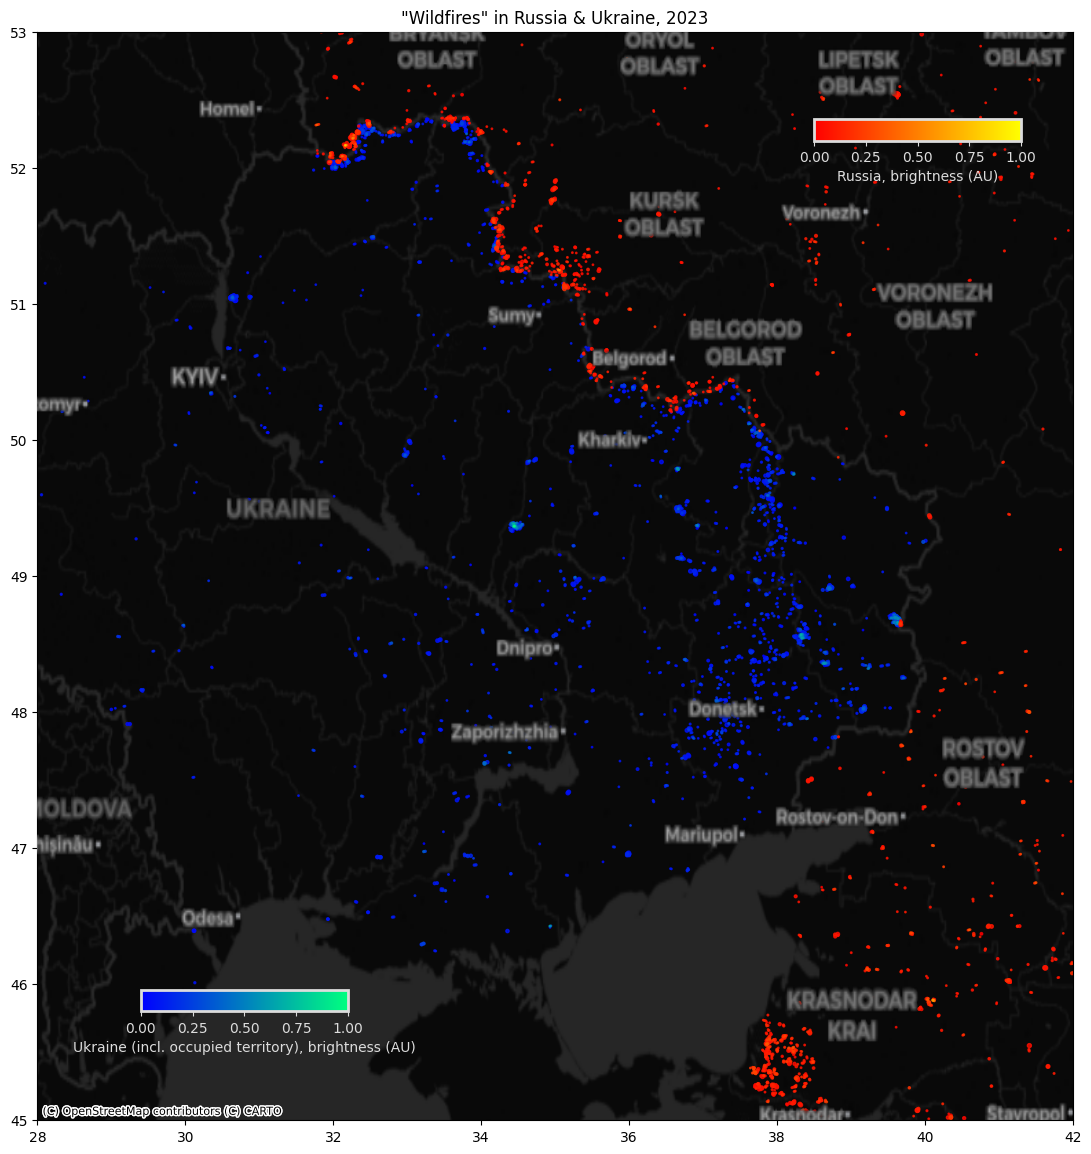

In [25]:

plt.clf()
plt.cla()

long_min = 45
long_max = 53
lat_min = 28
lat_max = 42


# set our extent
w = lat_max - lat_min
h = long_max - long_min
ratio = w / h

fig, ax = plt.subplots(figsize=(20, 20/ratio), layout="constrained")
world.plot(ax=ax, alpha=0, edgecolor=[0, 0, 0, 0])
ax.set_xlim([lat_min, lat_max])
ax.set_ylim([long_min, long_max])
# ax.set(title=f'"Wildfires" in Russia & Ukraine, past {past_n_days} days')
ax.set(title=f'"Wildfires" in Russia & Ukraine, 2023')

cx.add_basemap(
    ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.DarkMatterNoLabels
)
mean_br = df["brightness"].mean()
std_br = df["brightness"].std()
gdf["brightness (norm)"] = df["brightness"].apply(lambda x: (x-mean_br)/ std_br)
gdf[gdf["country"] == "UKR"].sort_values(by="brightness (norm)", ascending=True).plot(
    ax=ax,
    column="brightness (norm)",
    zorder=1,
    cmap="winter",
    alpha=0.8,
    markersize="area",
    legend=False,
    legend_kwds={
        "orientation": "vertical",
        "pad": 0.05,
        "shrink": 0.5,
        "label": "Ukraine (incl. occupied territory)",
    },
)
#fig.colorbar(ukr_plot, cax=cbar_one, orientation="horizontal", label="Ukraine (incl. occupied territory)")
gdf[gdf["country"] == "RUS"].sort_values(by="brightness (norm)", ascending=True).plot(
    ax=ax,
    column="brightness (norm)",
    zorder=1,
    cmap="autumn",
    alpha=0.8,
    markersize="area",
    legend=False,
    legend_kwds={
        "orientation": "vertical",
        "pad": 0.05,
        "shrink": 0.5,
        "label": "Russia",
    },
)
cx.add_basemap(
    ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.DarkMatterOnlyLabels
)
#cbaxes = inset_axes(ax, width="25%", height="2%", loc="lower left")
cbaxes = ax.inset_axes((0.1, 0.1, 0.2, 0.02))
cbar = ColorbarBase(cbaxes, cmap='winter', orientation="horizontal")
cbar.outline.set_color('gainsboro')
cbar.outline.set_linewidth(2)
cbar.set_label("Ukraine (incl. occupied territory), brightness (AU)", color="gainsboro")
cbar.ax.xaxis.set_tick_params(color="gainsboro")
plt.setp(plt.getp(cbaxes, 'xticklabels'), color="gainsboro")
cbar.outline.set_edgecolor("gainsboro")

cbaxes = ax.inset_axes((0.75, 0.90, 0.2, 0.02))
cbar = ColorbarBase(cbaxes, cmap='autumn', orientation="horizontal")
cbar.outline.set_edgecolor('gainsboro')
cbar.outline.set_linewidth(2)
cbar.set_label("Russia, brightness (AU)", color="gainsboro")
cbar.ax.xaxis.set_tick_params(color="gainsboro")
plt.setp(plt.getp(cbaxes, 'xticklabels'), color="gainsboro")
cbar.outline.set_edgecolor("gainsboro")
plt.show()

We can use matplotlibs rectangle selector to select a region of interest from these plots, & use those coordinates for further analysis

In [29]:
from matplotlib.widgets import RectangleSelector


def line_select_callback(eclick, erelease):
    pass


def make_selection(ax):
    r_select = RectangleSelector(
        ax,
        line_select_callback,
        useblit=True,
        button=[1],
        minspanx=5,
        minspany=5,
        spancoords="data",
        use_data_coordinates=True,
        interactive=True,
    )
    return r_select


def select_plot(gdf, world, lat_min, lat_max, long_min, long_max):
    global selection_finished
    global waiting_for_selection
    waiting_for_selection = True
    selection_finished = False

    # Plot code
    ax = world.plot(figsize=(20, 20 / ratio), alpha=0, edgecolor=[0, 0, 0, 0])
    ax.set_xlim([lat_min, lat_max])
    ax.set_ylim([long_min, long_max])
    ax.set(title='"Wildfires" in Russia & Ukraine, past 4 days')

    gdf.plot(ax=ax, column="brightness", cmap="autumn", alpha=0.8, markersize="area")
    cx.add_basemap(ax, crs=gdf.crs.to_string(), attribution_size=5)
    ax.set_axis_off()

    plt.show()

    r_select = make_selection(ax)
    return r_select

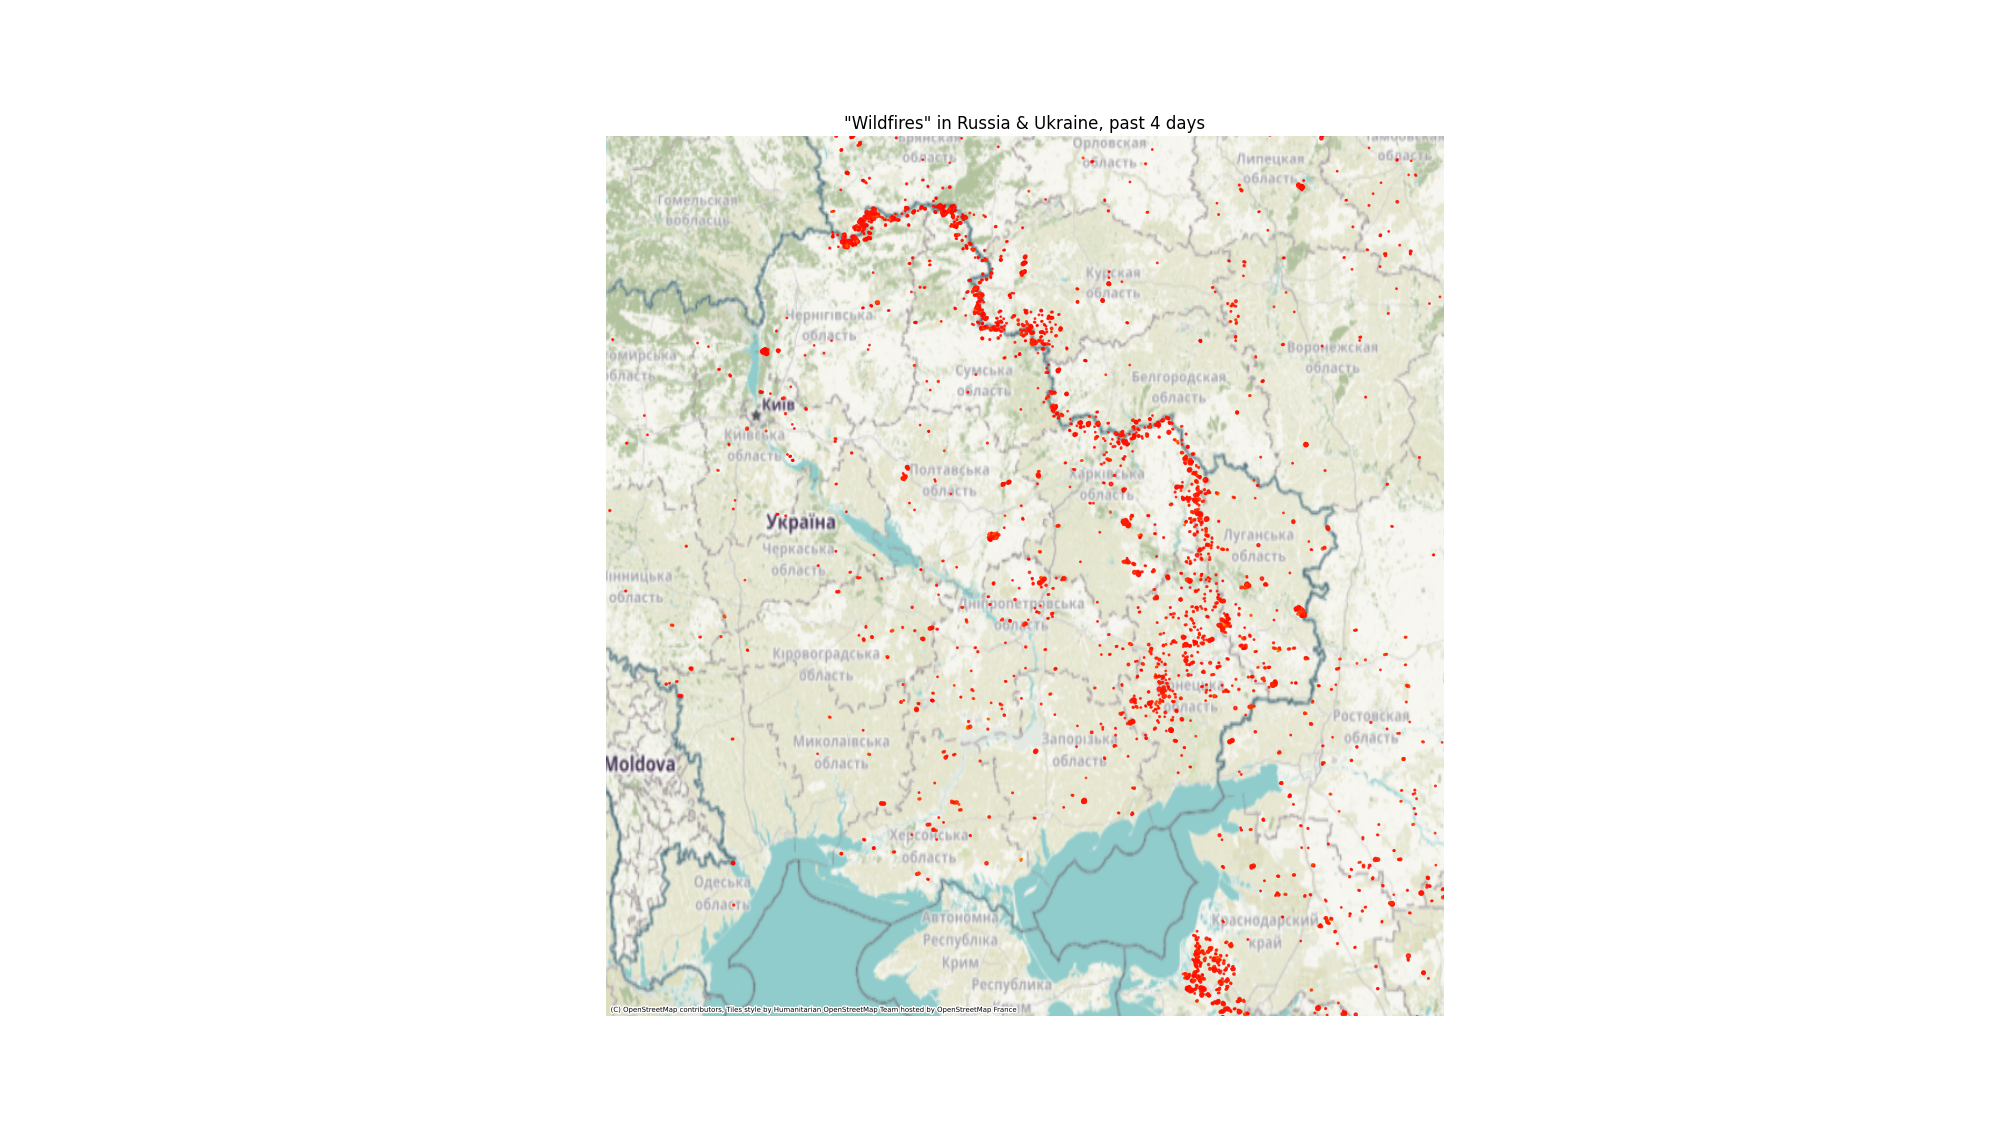

In [31]:
%matplotlib widget
plt.cla()
plt.clf()
r_select = select_plot(gdf, world,  lat_min, lat_max, long_min, long_max)

In [32]:
selection = r_select.extents
def select_to_bbox(selection):
    return [
        selection[0],
        selection[2],
        selection[1],
        selection[3]
    ]

In [33]:
%matplotlib inline

In [34]:
def select_gps_box(gdf, bbox):
    # bbox: [x1, y1, x2, y2]
    return gdf[
        (gdf["longitude"] > bbox[0])
        & (gdf["longitude"] < bbox[1])
        & (gdf["latitude"] > bbox[2])
        & (gdf["latitude"] < bbox[3])
    ]


gdf_select = select_gps_box(gdf, selection)

In [38]:
df_daily = gdf_select[["acq_date", "brightness"]].groupby(["acq_date"]).sum().reset_index()
df["acq_date"] = pd.to_datetime(df["acq_date"]).dt.date

fig = px.line(df_daily, x="acq_date", y="brightness")
fig.show()


# Using pgeocode to query specific locations by name
First we will get some longer term data (all of 2022) from NASAs dedicated download site
For historic data (as far back as 2000 depending on source) https://firms.modaps.eosdis.nasa.gov/download/create.php


In [39]:
ua_22 = pd.read_csv("data/modis/2022/modis_2022_Ukraine.csv" )
ru_22 = pd.read_csv("data/modis/2022/modis_2022_Russian_Federation.csv" )

In [40]:
ua_22["country"] = "UKR"
ru_22["country"]="RUS"
df_22 = pd.concat([ua_22, ru_22])

In [41]:
nomi = pgc.Nominatim("ua")

In [42]:
loc_dict = {
    "Kyiv": "Київ",
    "Kharkiv": "Харків",
    "Bakhmut": "Бахмут",
    "Mariupol": "Маріуполь",
    "Odesa": "Одеса"
}

Extracting time-series data from 'bounding boxes' surrouding these regions

In [45]:


def select_gps_box(gdf, bbox):
    # bbox: [x1, y1, x2, y2]
    return gdf[
        (gdf["latitude"] > bbox[0])
        & (gdf["longitude"] < bbox[1])
        & (gdf["latitude"] > bbox[2])
        & (gdf["longitude"] < bbox[3])
    ]



for idx, loc in enumerate(loc_dict.keys()):
    search_loc = loc_dict[loc]
    loc_df = nomi.query_location(search_loc, top_k=1, fuzzy_threshold=90)
    lat = loc_df["latitude"].values[0]
    long = loc_df["longitude"].values[0]
    box_size = 50

    #1km is (very) approximately 0.01 degrees of lat/long unless near the poles so for [x1, y1, x2, y2] bounding box
    box = [
        lat - box_size/100,
        long - box_size/100,
        lat + box_size/100,
        long + box_size/100

    ]
    focus_df = select_gps_box(ua_22, box)
    focus_df["location"] = loc
    focus_df["location_cyr"] = search_loc
    if idx == 0:
        agg_df = focus_df
    else:
        agg_df = pd.concat([agg_df, focus_df])

df_daily = agg_df[["acq_date", "location", "location_cyr", "brightness"]].groupby(["acq_date", "location", "location_cyr"]).sum().reset_index()
df["acq_date"] = pd.to_datetime(df["acq_date"]).dt.date

fig = px.line(df_daily, x="acq_date", y="brightness", color="location")
fig.show()



# Animated time-lapse (WIP, not functional yet)

In [46]:
search_loc="Харків"
eng_label = "Kharkiv"
loc_df = nomi.query_location(search_loc, top_k=1, fuzzy_threshold=90)
lat = loc_df["latitude"].values[0]
long = loc_df["longitude"].values[0]

In [48]:
box_size = 50

#1km is (very) approximately 0.01 degrees of lat/long unless near the poles so for [x1, y1, x2, y2] bounding box
box = [
    lat - box_size/100,
    long - box_size/100,
    lat + box_size/100,
    long + box_size/100

]

In [49]:
def select_gps_box(gdf, bbox):
    # bbox: [x1, y1, x2, y2]
    return gdf[
        (gdf["latitude"] > bbox[0])
        & (gdf["longitude"] < bbox[1])
        & (gdf["latitude"] > bbox[2])
        & (gdf["longitude"] < bbox[3])
    ]

focus_df = select_gps_box(ua_22, box)

In [50]:
focus_df.shape

(2061, 16)

In [51]:
gdf = geopandas.GeoDataFrame(
    df_22, geometry=geopandas.points_from_xy(df_22.longitude, df_22.latitude), crs="EPSG:4326"
)
gdf["acq_date"] = pd.to_datetime(gdf["acq_date"]).dt.date
gdf["area"] = gdf["track"] * gdf["scan"]

In [52]:
%matplotlib notebook

In [53]:
def add_points(df, ax, cmap):
    df.sort_values(by="brightness (norm)", ascending=True).plot(
        ax=ax,
        column="brightness (norm)",
        zorder=1,
        cmap=cmap,
        alpha=0.8,
        markersize="area",
        legend=False,
    )

def add_cbar(ax, cmap, cbar_pos, cbar_label):
    cbaxes = ax.inset_axes(cbar_pos)
    cbar = ColorbarBase(cbaxes, cmap=cmap, orientation="horizontal")
    cbar.outline.set_color('gainsboro')
    cbar.outline.set_linewidth(2)
    cbar.set_label(cbar_label, color="gainsboro")
    cbar.ax.xaxis.set_tick_params(color="gainsboro")
    plt.setp(plt.getp(cbaxes, 'xticklabels'), color="gainsboro")
    cbar.outline.set_edgecolor("gainsboro")

def init_plot():
    mean_br = gdf["brightness"].mean()
    std_br = gdf["brightness"].std()
    gdf["brightness (norm)"] = gdf["brightness"].apply(lambda x: (x-mean_br)/ std_br)

    long_min = bounds[1]
    long_max = bounds[3]
    lat_min = bounds[0]
    lat_max = bounds[2]

    map_source = cx.providers.CartoDB.DarkMatterNoLabels

    # set our extent
    w = lat_max - lat_min
    h = long_max - long_min
    ratio = w / h

    fig, ax = plt.subplots(figsize=(20, 20/ratio), layout="constrained")
    world.plot(ax=ax, alpha=0, edgecolor=[0, 0, 0, 0])
    ax.set_xlim([lat_min, lat_max])
    ax.set_ylim([long_min, long_max])
    ax.set(title=f'"Wildfires" in Russia & Ukraine, 2023')
    cx.add_basemap(
        ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.DarkMatterNoLabels
    )
    add_cbar(ax=ax, cmap="winter", cbar_pos=(0.1, 0.1, 0.2, 0.02), cbar_label="Ukraine (incl. occupied territory), brightness (AU)")
    add_cbar(ax=ax, cmap="autumn", cbar_pos=(0.75, 0.90, 0.2, 0.02), cbar_label="Russia, brightness (AU)")
    cx.add_basemap(
        ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.DarkMatterOnlyLabels
    )

def anomaly_map(gdf, ax):
    add_points(gdf[gdf["country"]=="UKR"], ax=ax, cmap="winter")
    add_points(gdf[gdf["country"]=="RUS"], ax=ax, cmap="autumn")
    

In [54]:
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()

bounds = [28, 45, 42, 53]

mean_br = gdf["brightness"].mean()
std_br = gdf["brightness"].std()
gdf["brightness (norm)"] = gdf["brightness"].apply(lambda x: (x-mean_br)/ std_br)

long_min = bounds[1]
long_max = bounds[3]
lat_min = bounds[0]
lat_max = bounds[2]

map_source = cx.providers.CartoDB.DarkMatterNoLabels

# set our extent
w = lat_max - lat_min
h = long_max - long_min
ratio = w / h

fig, ax = plt.subplots(figsize=(20, 20/ratio), layout="constrained")
world.plot(ax=ax, alpha=0, edgecolor=[0, 0, 0, 0])
ax.set_xlim([lat_min, lat_max])
ax.set_ylim([long_min, long_max])
ax.set(title=f'"Wildfires" in Russia & Ukraine, 2022')

cx.add_basemap(
        ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.DarkMatterNoLabels
    )
add_cbar(ax=ax, cmap="winter", cbar_pos=(0.1, 0.1, 0.2, 0.02), cbar_label="Ukraine (incl. occupied territory), brightness (AU)")
add_cbar(ax=ax, cmap="autumn", cbar_pos=(0.75, 0.90, 0.2, 0.02), cbar_label="Russia, brightness (AU)")
cx.add_basemap(
    ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.DarkMatterOnlyLabels
)

def update(frame):
    frame_df = gdf[gdf["acq_date"]==frame]
    anomaly_map(frame_df, ax)
    return ax
    
df_22["acq_date"] = pd.to_datetime(df_22["acq_date"]).dt.date

dates = df_22["acq_date"].unique()

ani = animation.FuncAnimation(fig=fig, func=update, frames=dates, interval=30)
ani.save("test.gif")

ValueError: aspect must be finite and positive 

In [180]:
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>